In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
register_matplotlib_converters()
import seaborn as sns

import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px

In [2]:
!ls data

building_metadata.csv  test_data.h5	 valid_sm_custom_3fold.h5
leak.feather	       test_data_nw.h5	 valid_sm_custom_4fold.h5
leakage.feather        train.csv	 weather_test.csv
sample_submission.csv  train_data.h5	 weather_train.csv
test.csv	       train_data_nw.h5


In [3]:
train_data = pd.read_hdf("data/train_data.h5")

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19678704 entries, 0 to 19678703
Data columns (total 12 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               int8
primary_use           object
square_feet           int32
air_temperature       float16
dew_temperature       float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: datetime64[ns](1), float16(5), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 863.3+ MB


number of time series

In [5]:
train_data.loc[:, ["building_id","meter"]].drop_duplicates()

,building_id,meter
0,46,0
1,105,0
2,106,0
3,106,3
4,107,0
...,...,...
16479603,1221,0
17156341,1413,1
17435626,604,0
17995099,1327,2


In [6]:
train_data.meter_reading.describe()

count    1.967870e+07
mean     2.041720e+03
std      1.552932e+05
min      0.000000e+00
25%      2.075000e+01
50%      7.987000e+01
75%      2.631800e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

number of 0 readings

In [7]:
len(train_data.query("meter_reading == 0"))

1343496

### number of samples by time serie

In [8]:
n_samples_by_ts = train_data.groupby(["building_id","meter"]).size().reset_index(name='counts')

In [9]:
n_samples_by_ts.counts.describe()

count    2380.000000
mean     8268.363025
std      1091.557136
min        20.000000
25%      8445.500000
50%      8771.000000
75%      8783.000000
max      8784.000000
Name: counts, dtype: float64

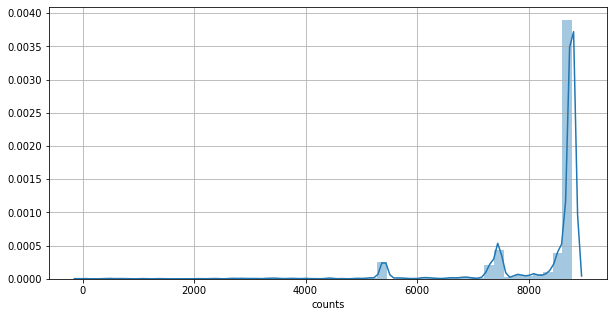

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(n_samples_by_ts.counts)
plt.grid()
plt.show()

### number of building by site 

In [11]:
(train_data.loc[:, ["site_id","building_id"]]
 .groupby("site_id")
 .apply(lambda df: df.building_id.unique().size)
 .reset_index(name="n_buildings"))

,site_id,n_buildings
0,0,105
1,1,51
2,2,135
3,3,274
4,4,91
5,5,89
6,6,44
7,7,15
8,8,70
9,9,124


***
### ts visualization

In [12]:
def plot_ts_by_site(site_id):
    train_data_cut = (train_data.query("site_id == @site_id")
                      .loc[:, ["timestamp","building_id","meter","meter_reading"]])
    for building_id in train_data_cut.building_id.unique():
        for meter in train_data_cut.meter.unique():
            print(f"building_id: {building_id} - meter: {meter}".center(90, "-"))
            ts = train_data_cut.query("building_id == @building_id & meter == @meter")
            plt.figure(figsize=(18,4))
            plt.plot_date(x=ts.timestamp.values, y=ts.meter_reading.values, fmt="r-")
            plt.grid()
            plt.show()

--------------------------------building_id: 46 - meter: 0--------------------------------


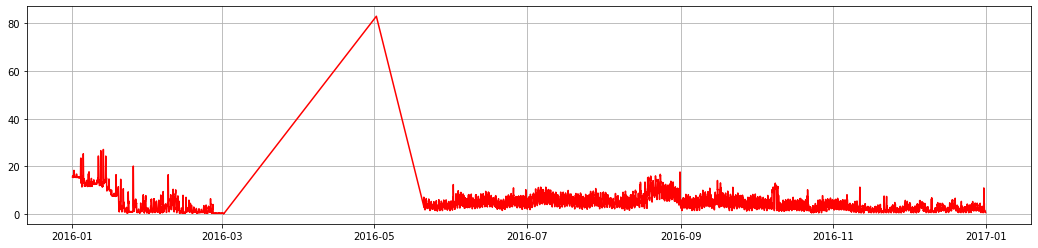

--------------------------------building_id: 46 - meter: 1--------------------------------


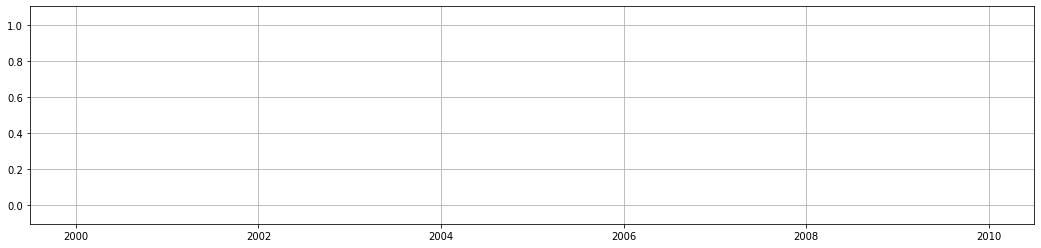

--------------------------------building_id: 7 - meter: 0---------------------------------


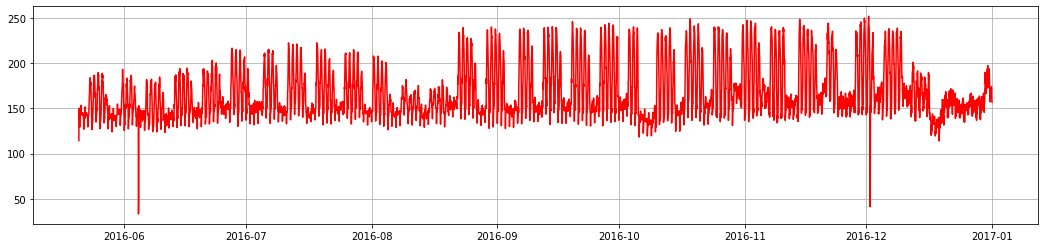

--------------------------------building_id: 7 - meter: 1---------------------------------


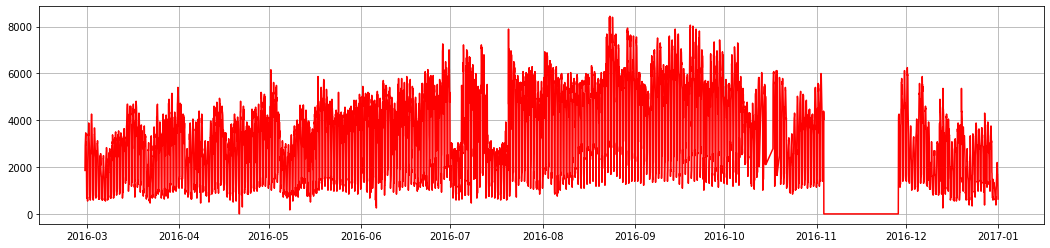

--------------------------------building_id: 9 - meter: 0---------------------------------


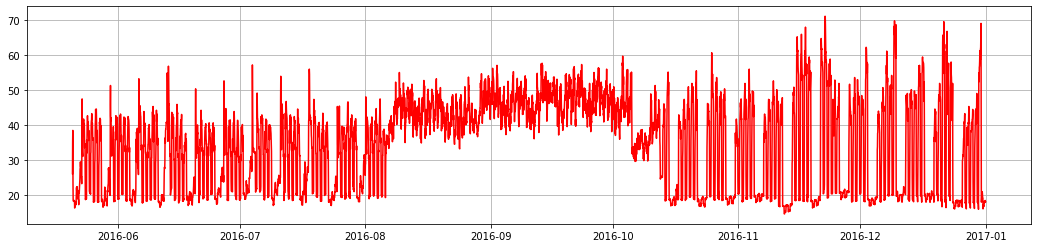

--------------------------------building_id: 9 - meter: 1---------------------------------


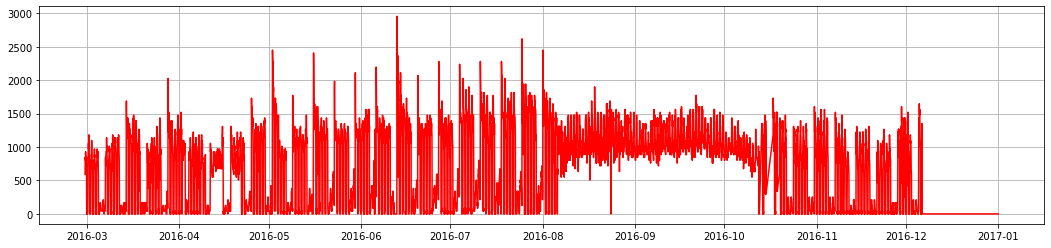

--------------------------------building_id: 13 - meter: 0--------------------------------


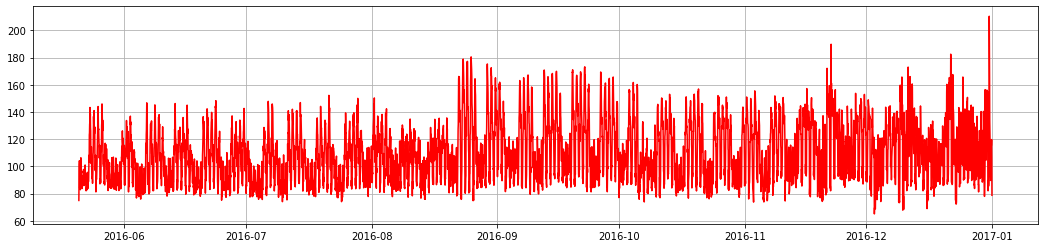

--------------------------------building_id: 13 - meter: 1--------------------------------


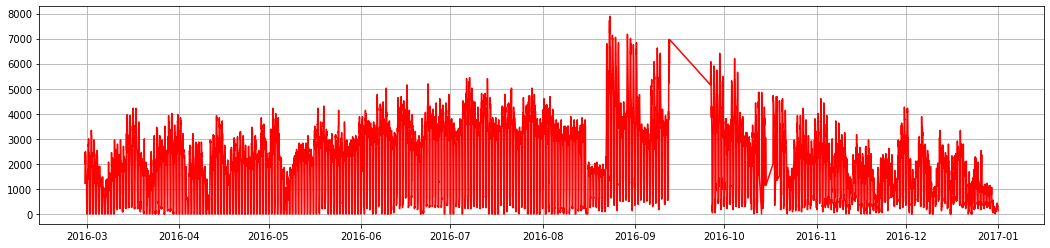

--------------------------------building_id: 14 - meter: 0--------------------------------


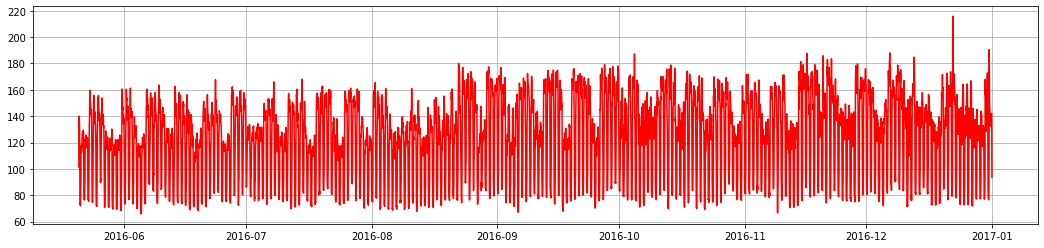

--------------------------------building_id: 14 - meter: 1--------------------------------


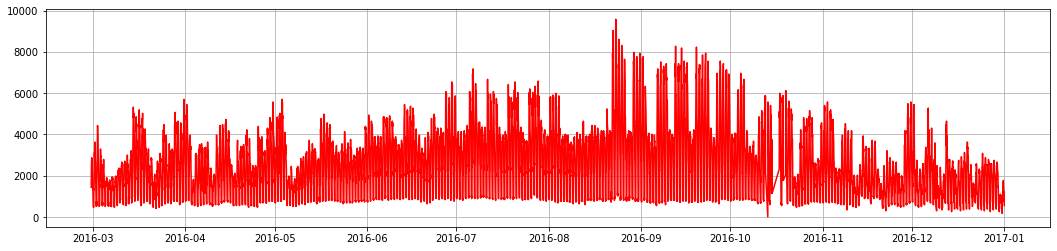

--------------------------------building_id: 15 - meter: 0--------------------------------


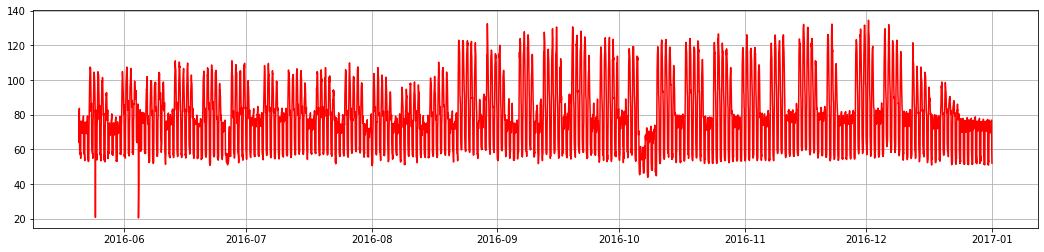

--------------------------------building_id: 15 - meter: 1--------------------------------


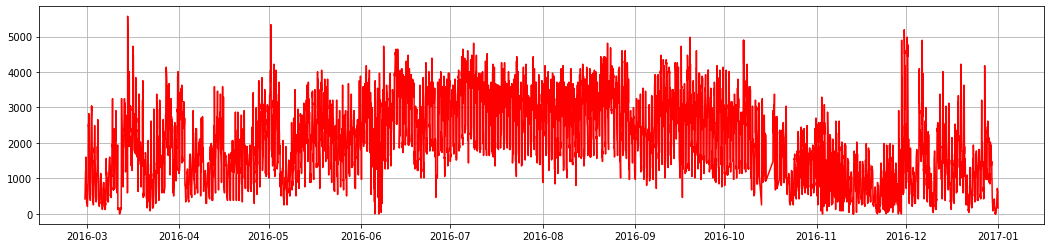

--------------------------------building_id: 29 - meter: 0--------------------------------


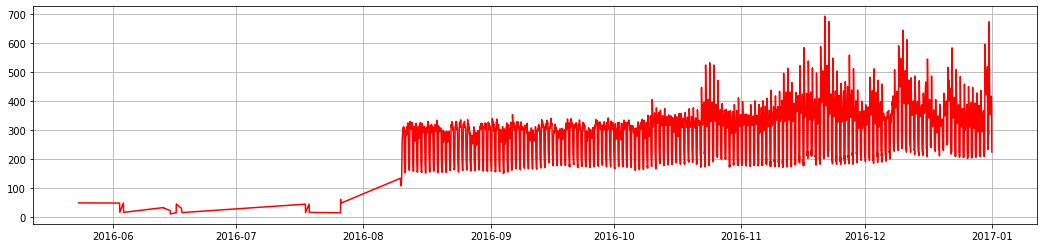

--------------------------------building_id: 29 - meter: 1--------------------------------


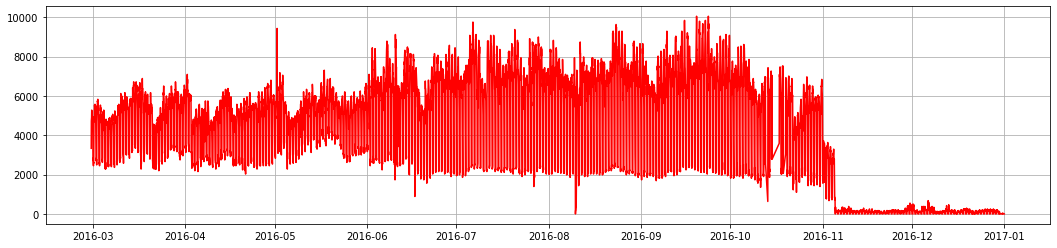

--------------------------------building_id: 30 - meter: 0--------------------------------


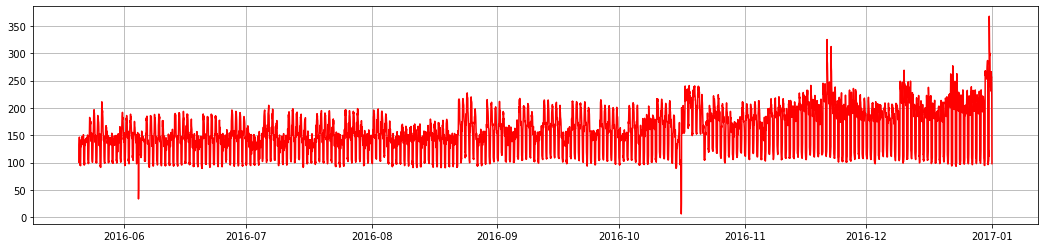

--------------------------------building_id: 30 - meter: 1--------------------------------


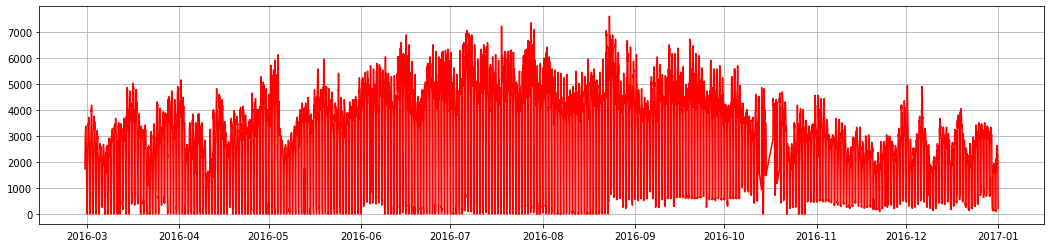

--------------------------------building_id: 31 - meter: 0--------------------------------


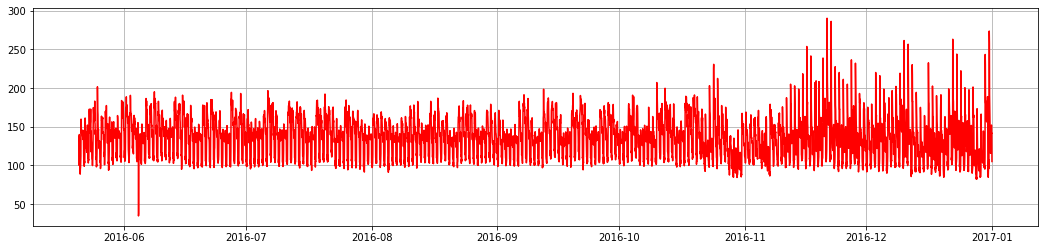

--------------------------------building_id: 31 - meter: 1--------------------------------


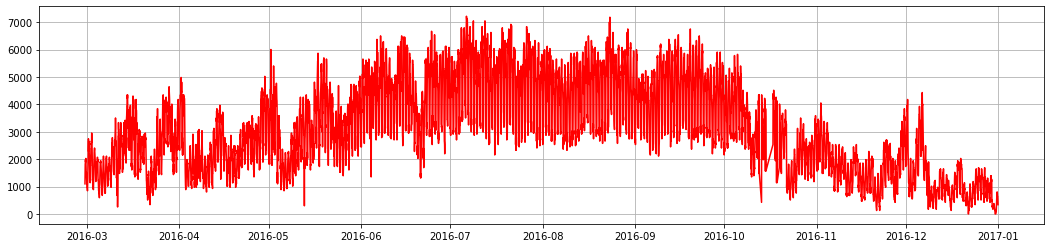

--------------------------------building_id: 43 - meter: 0--------------------------------


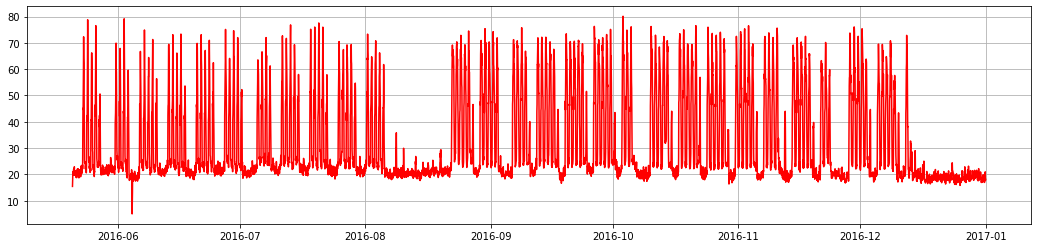

--------------------------------building_id: 43 - meter: 1--------------------------------


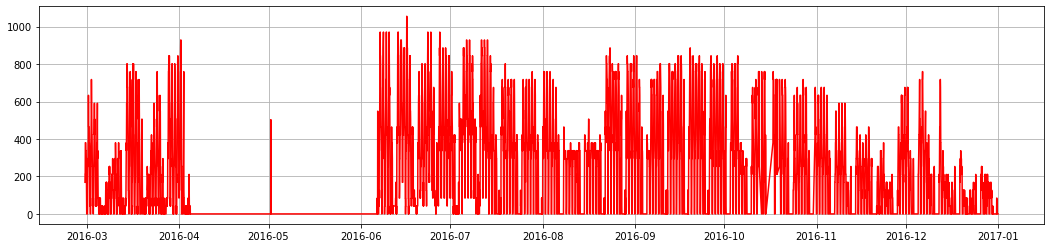

--------------------------------building_id: 50 - meter: 0--------------------------------


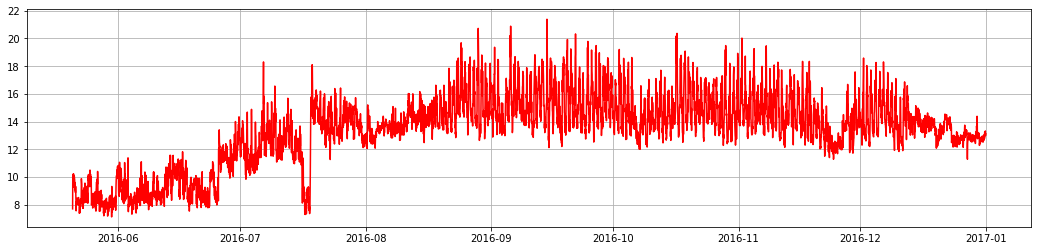

--------------------------------building_id: 50 - meter: 1--------------------------------


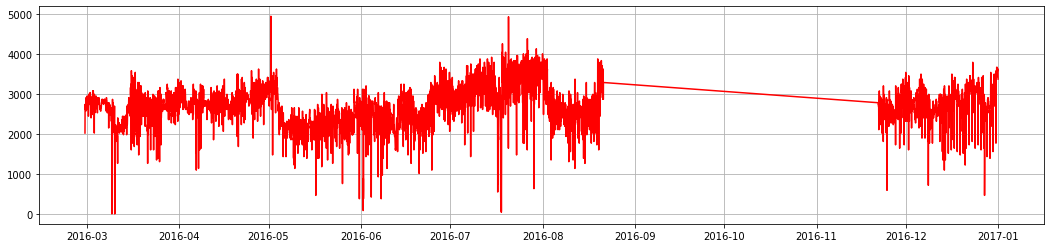

--------------------------------building_id: 55 - meter: 0--------------------------------


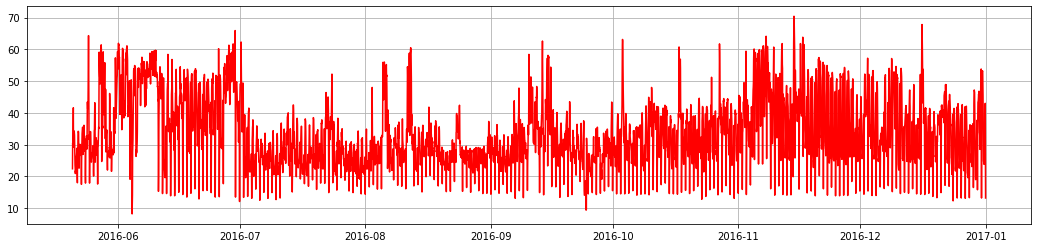

--------------------------------building_id: 55 - meter: 1--------------------------------


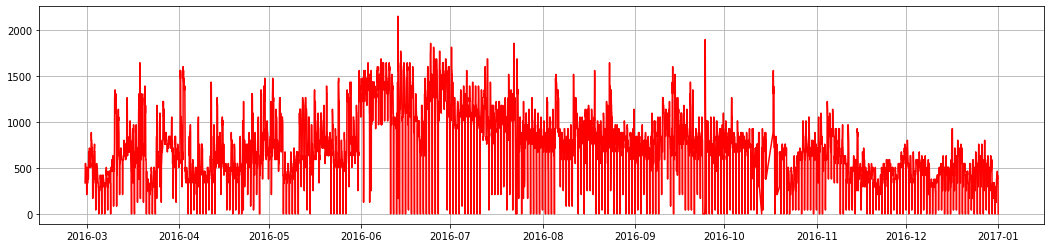

--------------------------------building_id: 60 - meter: 0--------------------------------


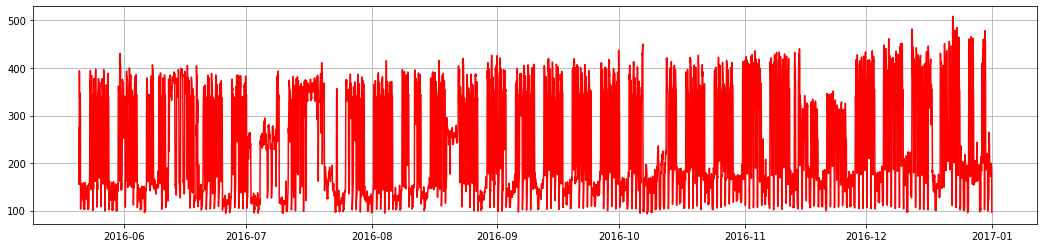

--------------------------------building_id: 60 - meter: 1--------------------------------


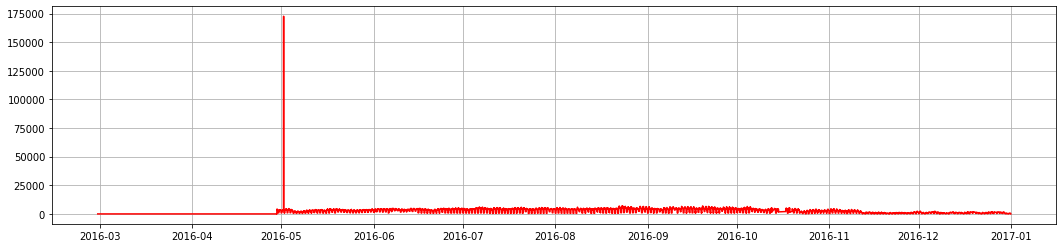

--------------------------------building_id: 75 - meter: 0--------------------------------


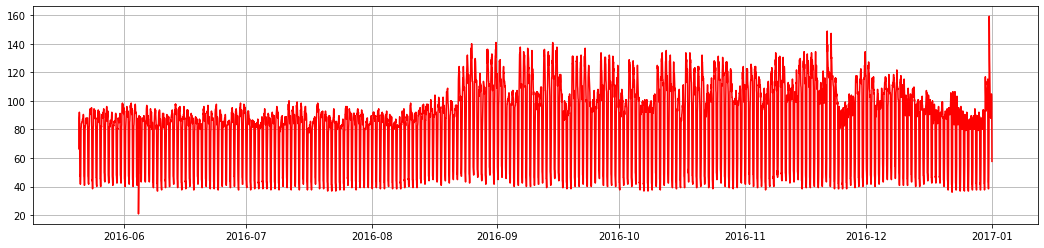

--------------------------------building_id: 75 - meter: 1--------------------------------


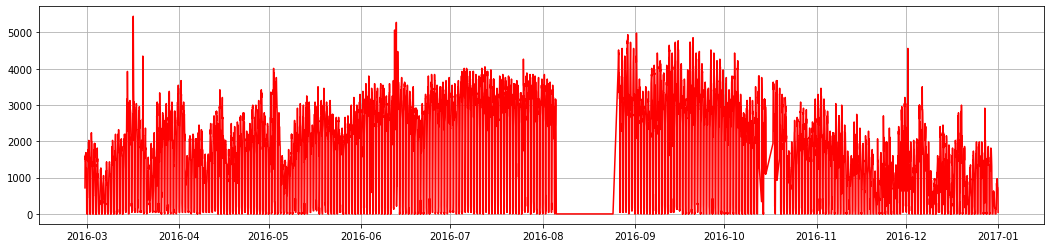

--------------------------------building_id: 76 - meter: 0--------------------------------


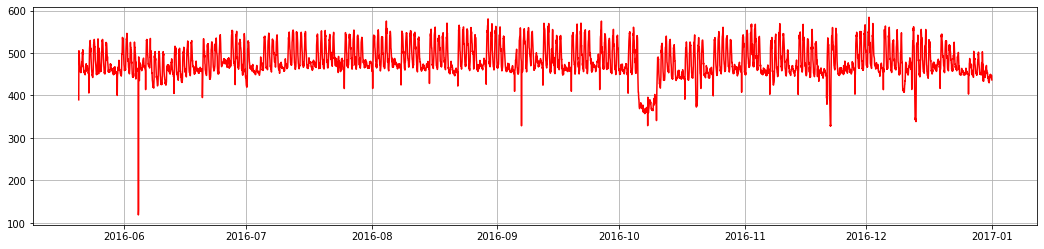

--------------------------------building_id: 76 - meter: 1--------------------------------


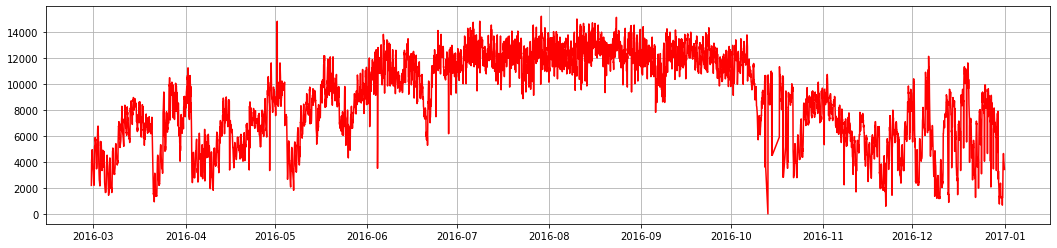

--------------------------------building_id: 78 - meter: 0--------------------------------


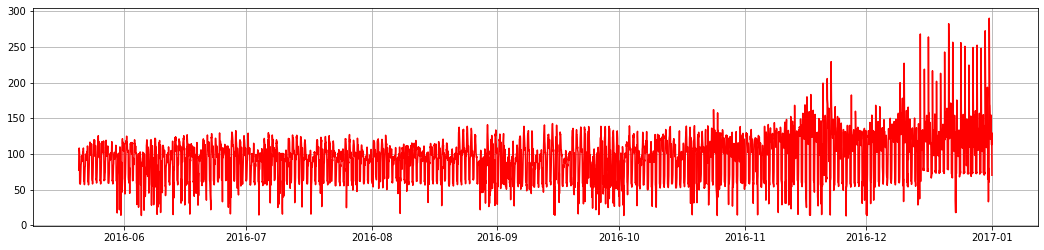

--------------------------------building_id: 78 - meter: 1--------------------------------


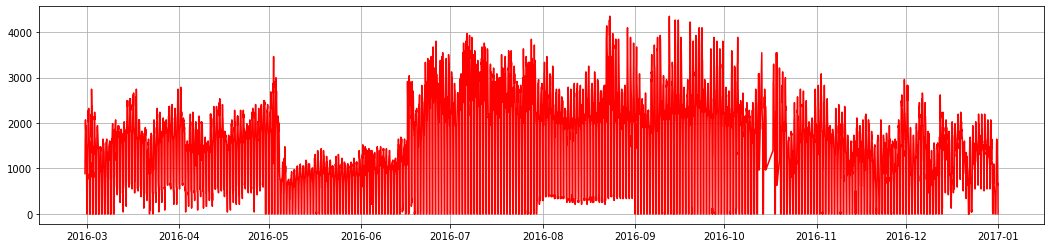

--------------------------------building_id: 82 - meter: 0--------------------------------


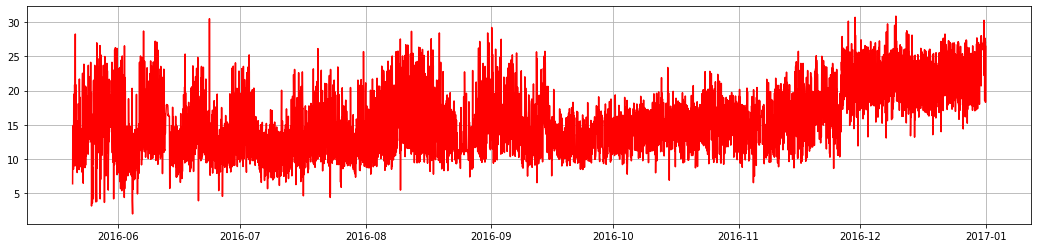

--------------------------------building_id: 82 - meter: 1--------------------------------


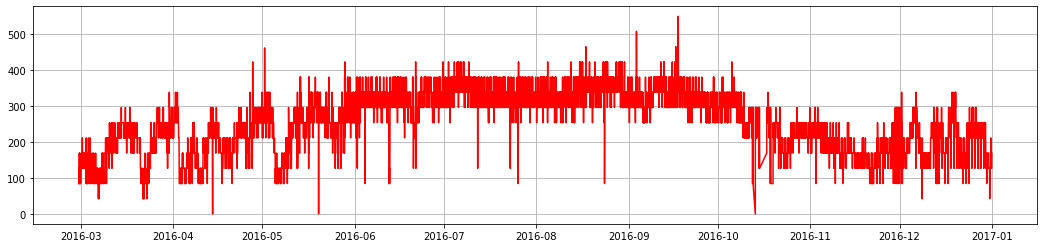

--------------------------------building_id: 91 - meter: 0--------------------------------


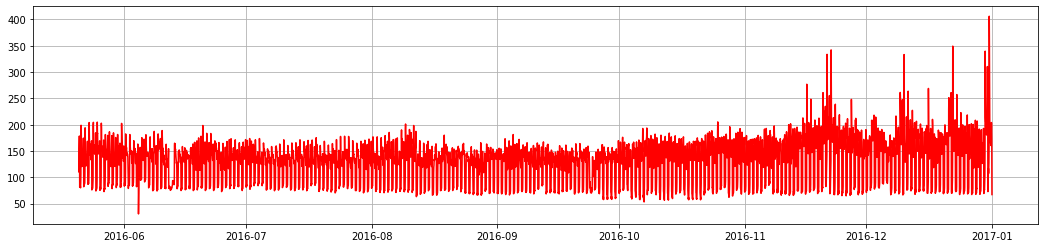

--------------------------------building_id: 91 - meter: 1--------------------------------


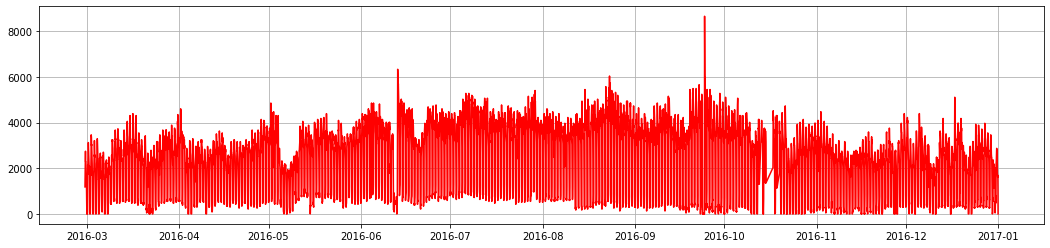

--------------------------------building_id: 92 - meter: 0--------------------------------


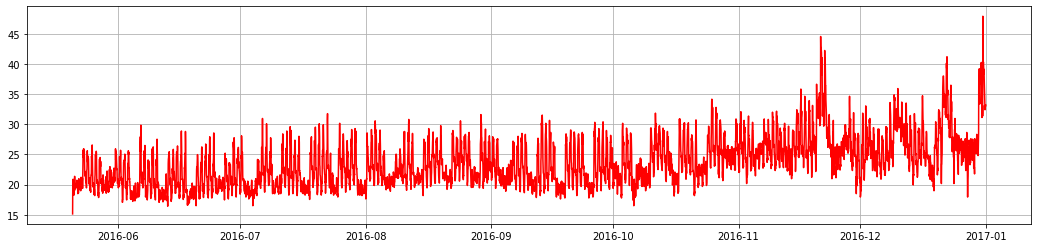

--------------------------------building_id: 92 - meter: 1--------------------------------


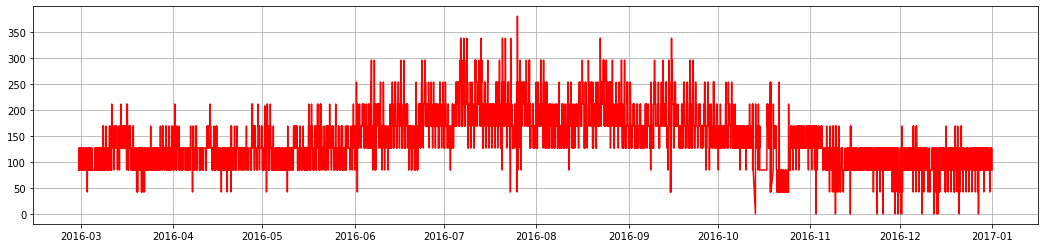

--------------------------------building_id: 95 - meter: 0--------------------------------


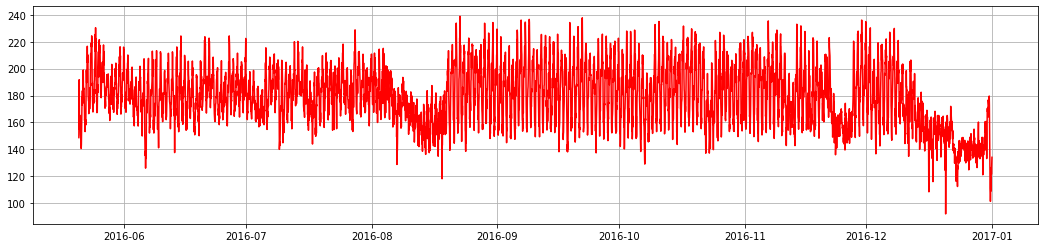

--------------------------------building_id: 95 - meter: 1--------------------------------


KeyboardInterrupt: 

In [13]:
plot_ts_by_site(0)

***
### data cleaning for `site_id=0`

In [ ]:
train_data_cut = train_data.query("site_id == 0")
ts_uid_values = train_data_cut.loc[:, ["building_id", "meter"]].drop_duplicates()
delete_idx = pd.Index(np.array([], dtype=int))
for i,row in ts_uid_values.iterrows():
    ts = train_data_cut.query("building_id == @row.building_id & meter == @row.meter")
    if ts.query("timestamp < '2016-05-20 18:00:00'").meter_reading.quantile(0.75) == 0:
        delete_idx = delete_idx.union(ts.query("timestamp < '2016-05-20 18:00:00'").index)

In [ ]:
train_data.drop(delete_idx, axis=0, inplace=True)

In [ ]:
len(train_data)

***
### hourly patter for air temperature by `site_id`

In [ ]:
weather_train = pd.read_csv("data/weather_train.csv", parse_dates=["timestamp"])
weather_train["hour"] = weather_train.timestamp.dt.hour
hourly_temp = weather_train.groupby(["site_id","hour"])["air_temperature"].mean().reset_index()

In [ ]:
for site_id in hourly_temp.site_id.unique():
    print(f"hourly temperature for site: {site_id}")
    ts = hourly_temp.query("site_id == @site_id")
    plt.figure(figsize=(13,6))
    plt.plot(ts.hour.values, ts.air_temperature.values, "o--")
    plt.grid()
    plt.show()

### fix to set weather data to its local time

In [ ]:
sites_time_corrections = {0:4, 1:0, 2:7, 3:4, 4:7, 5:0, 6:4, 7:4, 8:4,
                          9:5, 10:7, 11:4, 12:0, 13:5, 14:4, 15:4}

def set_localtime(data):
    data = data.copy(deep=True)
    min_timestamp = data.timestamp.min()
    for site_id, hdiff in sites_time_corrections.items():
        idx = data.query("site_id == @site_id").index 
        data.loc[idx, "timestamp"] = data.loc[idx, "timestamp"] - pd.offsets.Hour(hdiff)
    return data.query("timestamp >= @min_timestamp")

In [ ]:
hourly_temp = _weather_train.groupby(["site_id","hour"])["air_temperature"].mean().reset_index()

In [ ]:
for site_id in hourly_temp.site_id.unique():
    print(f"hourly temperature for site: {site_id}")
    ts = hourly_temp.query("site_id == @site_id")
    plt.figure(figsize=(13,6))
    plt.plot(ts.hour.values, ts.air_temperature.values, "o--")
    plt.grid()
    plt.show()

### imputation of missing values in weather data

In [ ]:
weather_train.describe()

In [ ]:
print(weather_train.precip_depth_1_hr.quantile(0.93))
print(weather_train.precip_depth_1_hr.quantile(0.94))

#### number of nans

In [ ]:
weather_train.isna().sum()

In [ ]:
100*weather_train.isna().sum()/weather_train.shape[0]

In [ ]:
weather_train.groupby('site_id').apply(lambda group: group.isna().sum())

In [ ]:
df = (weather_train
      .set_index("timestamp")
      .groupby('site_id')
      .apply(lambda group: group.interpolate(method="time", limit_direction='both'))
      .reset_index())

In [ ]:
df.groupby('site_id').apply(lambda group: group.isna().sum())

***
### hourly patter for meter_reading per `site_id` and for `meter==0`

In [ ]:
train_data["hour"] = train_data.timestamp.dt.hour
train_data_cut = train_data.query("meter == 0")

In [ ]:
hourly_reading = train_data_cut.groupby(["site_id","hour"])["meter_reading"].sum().reset_index()

hourly meter_reading (meter==0) for site: 0


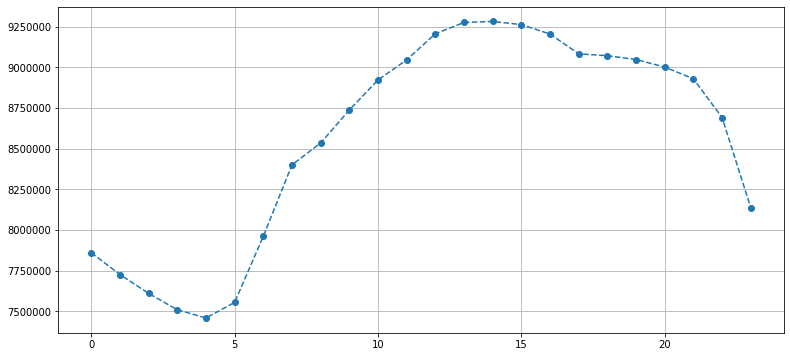

hourly meter_reading (meter==0) for site: 1


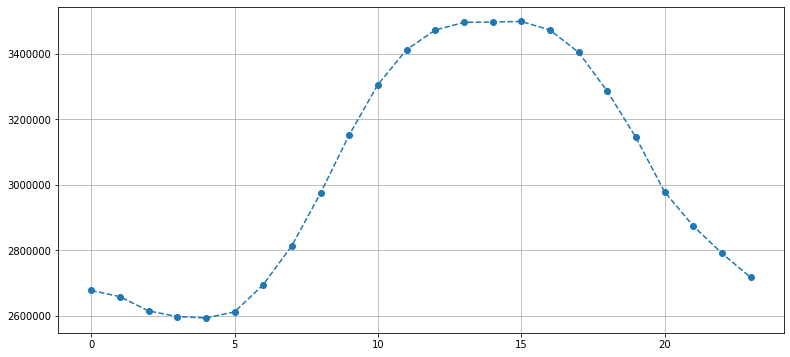

hourly meter_reading (meter==0) for site: 2


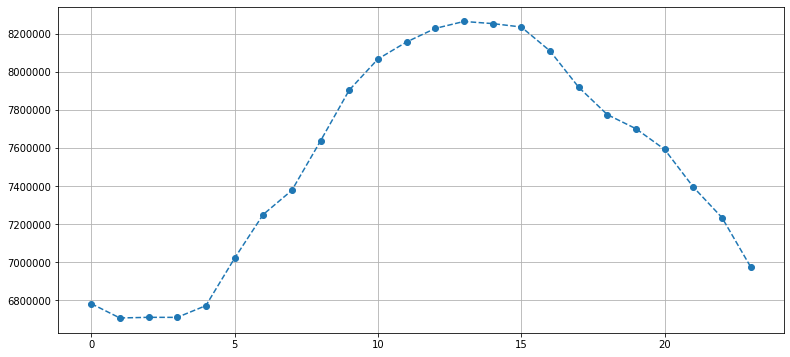

hourly meter_reading (meter==0) for site: 3


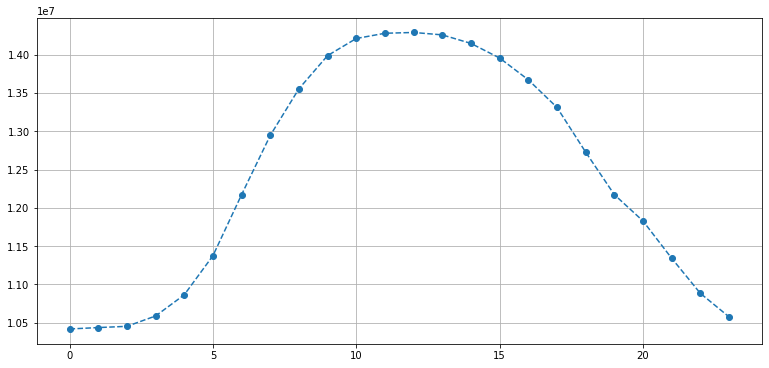

hourly meter_reading (meter==0) for site: 4


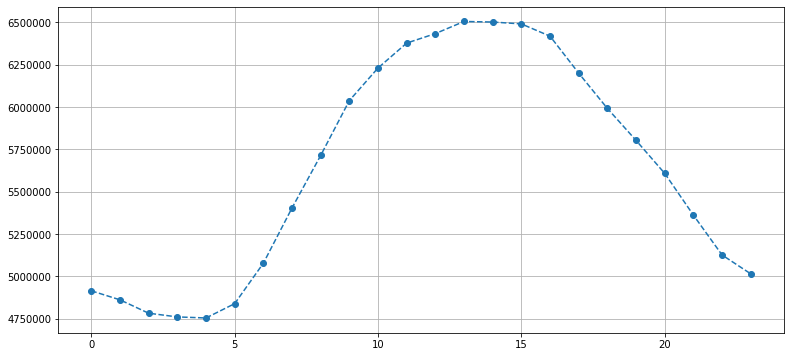

hourly meter_reading (meter==0) for site: 5


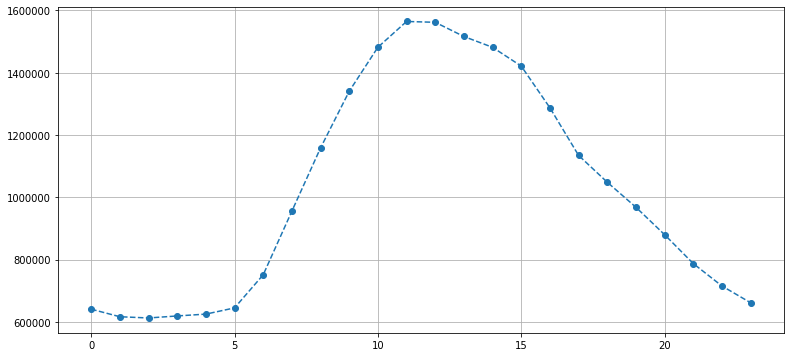

hourly meter_reading (meter==0) for site: 6


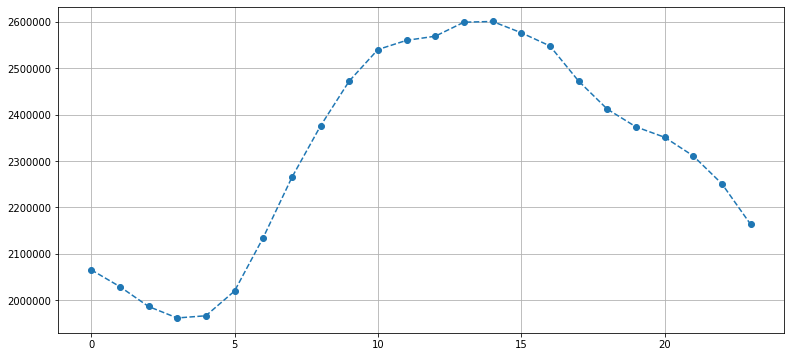

hourly meter_reading (meter==0) for site: 7


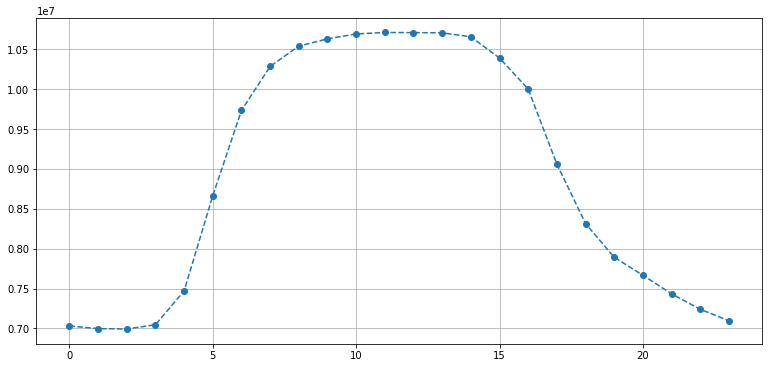

hourly meter_reading (meter==0) for site: 8


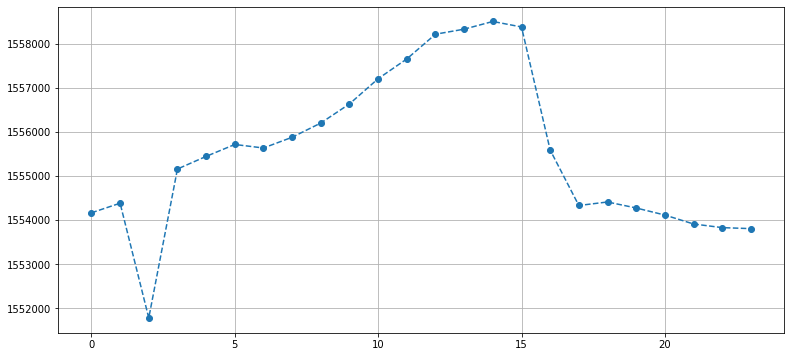

hourly meter_reading (meter==0) for site: 9


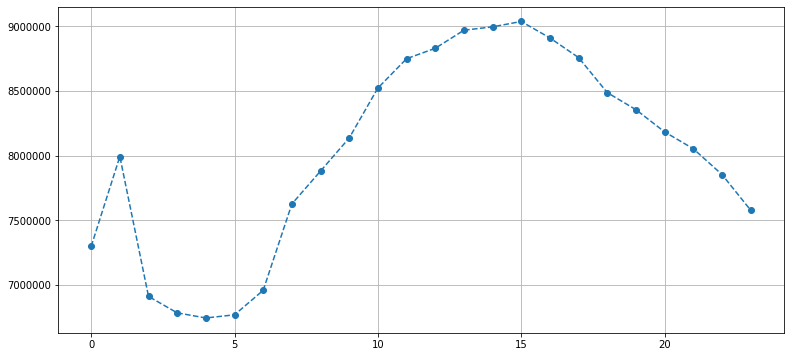

hourly meter_reading (meter==0) for site: 10


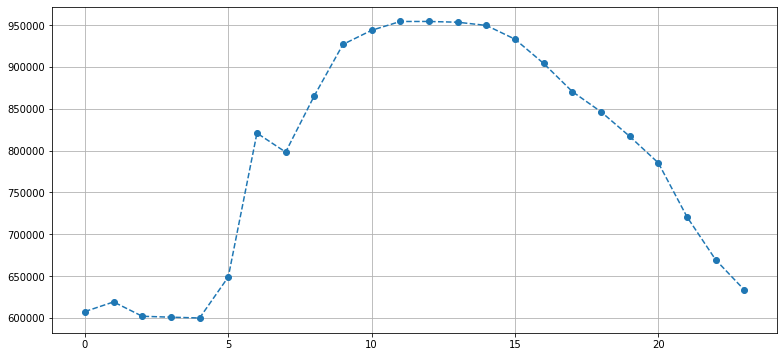

hourly meter_reading (meter==0) for site: 11


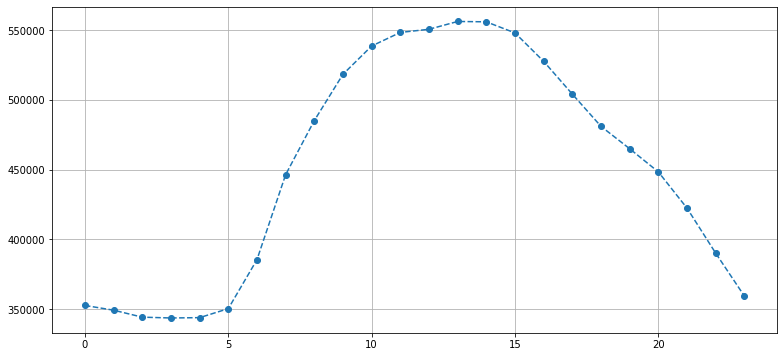

hourly meter_reading (meter==0) for site: 12


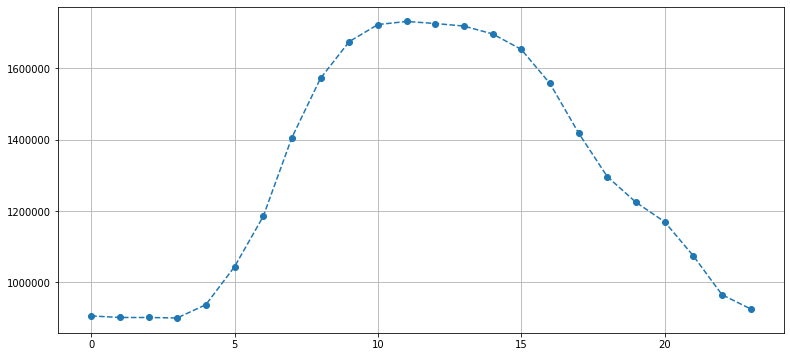

hourly meter_reading (meter==0) for site: 13


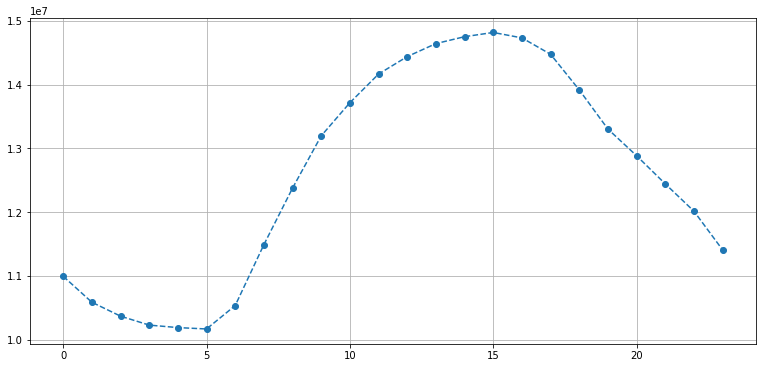

hourly meter_reading (meter==0) for site: 14


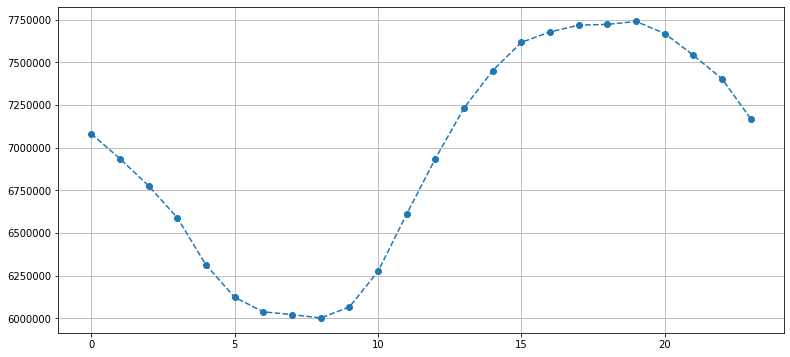

hourly meter_reading (meter==0) for site: 15


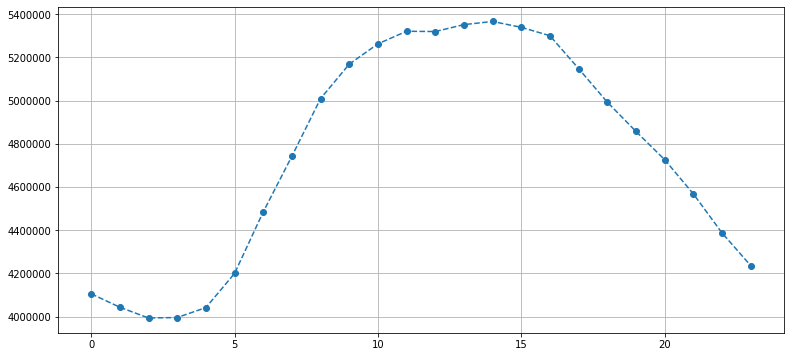

In [43]:
for site_id in hourly_reading.site_id.unique():
    print(f"hourly meter_reading (meter==0) for site: {site_id}")
    ts = hourly_reading.query("site_id == @site_id")
    plt.figure(figsize=(13,6))
    plt.plot(ts.hour.values, ts.meter_reading.values, "o--")
    plt.grid()
    plt.show()

***
### `building_id = 363`

In [8]:
ts = train_data.query("building_id == 363 & meter == 0")

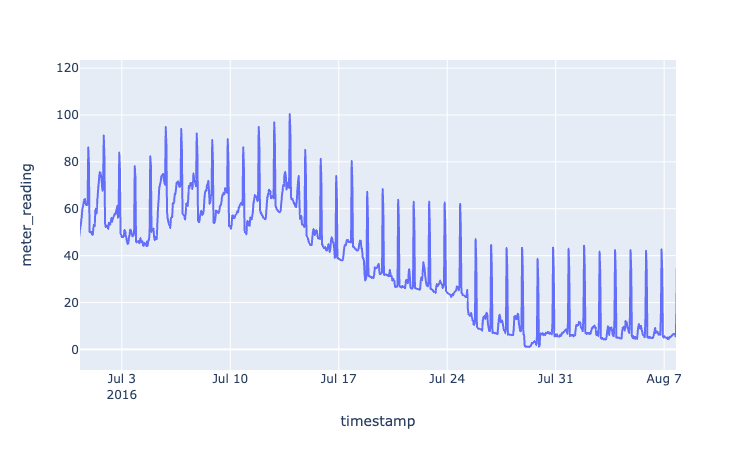

In [10]:
fig = px.line(ts, x='timestamp', y='meter_reading')
fig.show()

25jul start normal behavior for `building_id = 363` and `meter = 0`

In [12]:
idx = train_data.query("building_id == 363 & meter == 0 & timestamp <= '2016-07-24 23:00:00'").index
train_data.drop(idx, axis=0).reset_index(drop=True)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
421,363,0,2016-01-01 00:00:00,32.049999,3,Education,69300,10.000000,2.199219,NaN,1021.0,350.0,4.101562
2618,363,0,2016-01-01 01:00:00,32.570000,3,Education,69300,9.398438,2.800781,0.0,1021.5,350.0,6.199219
4811,363,0,2016-01-01 02:00:00,32.799999,3,Education,69300,8.898438,2.199219,0.0,1021.5,10.0,4.601562
7007,363,0,2016-01-01 03:00:00,33.919998,3,Education,69300,7.800781,1.099609,0.0,1021.5,350.0,7.699219
9200,363,0,2016-01-01 04:00:00,35.580002,3,Education,69300,7.800781,0.600098,0.0,1022.0,340.0,4.101562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10891828,363,0,2016-07-24 19:00:00,27.270000,3,Education,69300,35.000000,19.406250,0.0,1015.0,150.0,2.099609
10894150,363,0,2016-07-24 20:00:00,62.029999,3,Education,69300,35.593750,19.406250,0.0,1014.5,130.0,2.099609
10896469,363,0,2016-07-24 21:00:00,52.029999,3,Education,69300,35.593750,20.593750,0.0,1014.0,170.0,3.099609
10898788,363,0,2016-07-24 22:00:00,24.020000,3,Education,69300,35.000000,21.093750,0.0,1014.0,170.0,4.601562


In [11]:
train_data.timestamp

0          2016-01-01 00:00:00
1          2016-01-01 00:00:00
2          2016-01-01 00:00:00
3          2016-01-01 00:00:00
4          2016-01-01 00:00:00
                   ...        
19871162   2016-12-31 23:00:00
19871163   2016-12-31 23:00:00
19871164   2016-12-31 23:00:00
19871165   2016-12-31 23:00:00
19871166   2016-12-31 23:00:00
Name: timestamp, Length: 19871167, dtype: datetime64[ns]

***
## analysis of leak data

In [5]:
leak_data = pd.read_feather("data/leakage.feather")

***
number of buildings by meter 

In [6]:
n_building = len(train_data.building_id.unique())
print(f"n_building in train: {n_building}")

n_building in train: 1449


In [7]:
train_data.groupby("meter").apply(lambda x: len(x.building_id.unique()))

meter
0    1413
1     498
2     324
3     145
dtype: int64

In [8]:
train_data.groupby("meter").apply(lambda x: len(x.building_id.unique())/n_building)

meter
0    0.975155
1    0.343685
2    0.223602
3    0.100069
dtype: float64

In [9]:
n_building = len(leak_data.building_id.unique())
print(f"n_building in leak: {n_building}")

n_building in leak: 463


In [10]:
leak_data.groupby("meter").apply(lambda x: len(x.building_id.unique()))

meter
0    424
1    165
2     43
3     55
dtype: int64

In [11]:
leak_data.groupby("meter").apply(lambda x: len(x.building_id.unique())/n_building)

meter
0    0.915767
1    0.356371
2    0.092873
3    0.118790
dtype: float64

***
number of `buildings & rows` by `site & meter`

In [43]:
df = (train_data.groupby(["site_id","meter"]).agg(
      n_buildings=("building_id", lambda x: len(x.unique())),
      n_rows=("timestamp", lambda x: len(x)))
      .reset_index())

In [45]:
df

,site_id,meter,n_buildings,n_rows
0,0,0,105,560062
1,0,1,24,167890
2,1,0,51,447978
3,1,3,12,105375
4,2,0,135,1174568
5,2,1,99,863845
6,2,3,55,481955
7,3,0,274,2362054
8,4,0,91,742867
9,5,0,89,773753


In [49]:
df = (leak_data.groupby(["site_id","meter"]).agg(
      n_buildings=("building_id", lambda x: len(x.unique())),
      n_rows=("timestamp", lambda x: len(x)))
      .reset_index())

In [50]:
df

,site_id,meter,n_buildings,n_rows
0,0,0,105,2364809
1,0,1,24,588733
2,1,0,50,1299462
3,2,0,134,3480562
4,2,1,98,2572023
5,2,3,55,1445555
6,4,0,74,1905561
7,15,0,61,1012598
8,15,1,43,718782
9,15,2,43,727682


***